In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from urllib.parse import unquote
import numpy as np
import os
import seaborn as sns
import networkx as nx

from preprocessing import WikispeediaData
from analysis_helpers import *
from plot_functions import *

### Reading data
Reading data and preprocessing it in WikispeediaData class

In [2]:
#Takes some time to run!
data = WikispeediaData()

data.count_articles()

In [95]:
data.articles.sort_values(by="nb_in_finished_paths", ascending=False).head(1)


,article_name,nb_in_unfinished_paths,nb_in_finished_paths,nb_links
4297,United States,3161,8482,3321


In [96]:
data.links.head(1)

,1st article,2nd article,different_cat
0,Áedán mac Gabráin,Bede,0.0


### Creating Hubs dataframe from data
Contains number of articles to a given article and number of articles from a given article. Mean shortest path to it and from it.

In [97]:
df_hubs = pd.DataFrame()
df_hubs["article_names"] = data.articles["article_name"]

#Printing wikipages with most links
source_counts = data.links['1st article'].value_counts()
df_hubs["source_counts"] = df_hubs["article_names"].map(source_counts).fillna(0).astype(int)

target_counts = data.links['2nd article'].value_counts()
df_hubs["target_counts"] = df_hubs["article_names"].map(target_counts).fillna(0).astype(int)


df_hubs["mean_shortest_path_to_article"] = np.nanmean(data.matrix, axis = 0)
df_hubs["mean_shortest_path"] = np.nanmean(data.matrix, axis = 1)

In [98]:
df_hubs.describe() 

,source_counts,target_counts,mean_shortest_path_to_article,mean_shortest_path
count,4604.000000,4604.000000,4604.000000,4604.000000
mean,26.038662,26.038662,2.829412,3.188769
std,24.201491,62.746827,1.170888,0.321702
min,0.000000,0.000000,0.000000,0.000000
25%,11.000000,2.000000,2.626172,3.025154
50%,19.000000,8.000000,2.989640,3.179408
75%,33.000000,25.000000,3.476390,3.344081
max,294.000000,1551.000000,6.866085,5.119852


In [99]:
#Adding categories to hubs dataframe
categories = np.unique(data.categories['1st cat'])
# Add a column for each category in categories_ha
for category in categories:
    articles_in_category = data.categories.loc[data.categories['1st cat'] == category, 'article_name']
    df_hubs[category] = np.where(df_hubs['article_names'].isin(articles_in_category), 1, 0)

In [100]:
df_hubs.head()

,article_names,source_counts,target_counts,mean_shortest_path_to_article,mean_shortest_path,Art,Business Studies,Citizenship,Countries,Design and Technology,Everyday life,Geography,History,IT,Language and literature,Mathematics,Music,People,Religion,Science
0,Áedán mac Gabráin,11,0,0.0,3.395464,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,Åland,19,0,0.0,3.127959,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,Édouard Manet,20,0,0.0,3.171598,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Éire,8,0,0.0,3.325937,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,Óengus I of the Picts,10,0,0.0,3.386834,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


### Plotting distributions 
Plotting distributions of number of links in articles, number of links to articles, categories, mean shortest path distance from articles, mean shorest distance to article. 

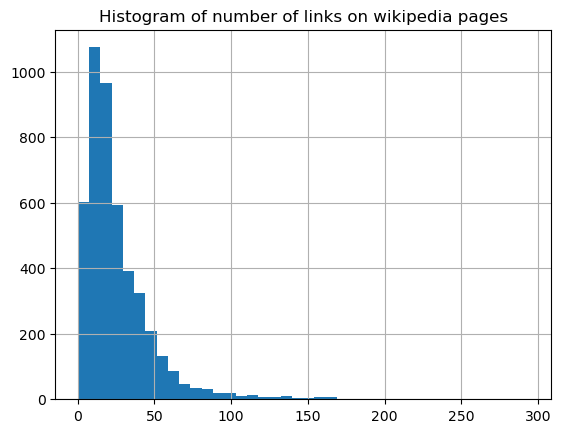

In [63]:
#Plotting distribution of links on wikipages
df_hubs.hist(column = "source_counts", bins = 40)
plt.title('Histogram of number of links on wikipedia pages')
plt.show()

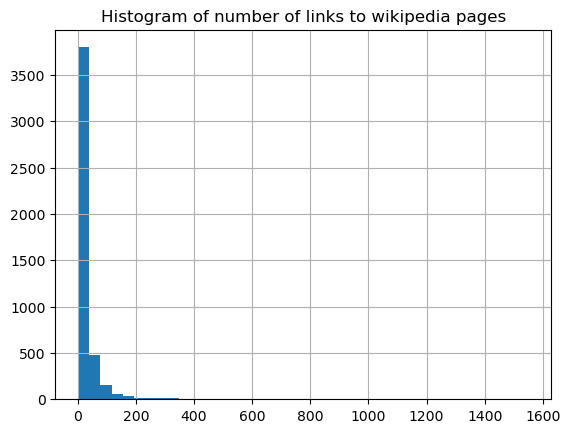

In [64]:
#Plotting distribution of links to wikipages
df_hubs.hist(column = "target_counts", bins = 40)
plt.title('Histogram of number of links to wikipedia pages')
plt.show()

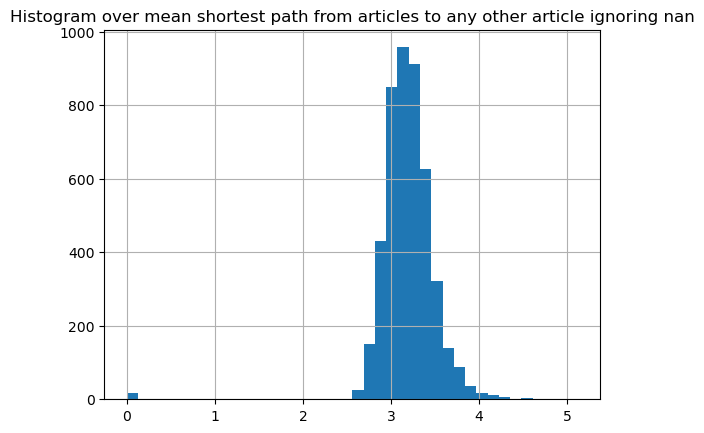

In [67]:
df_hubs.hist(column = "mean_shortest_path", bins = 40)
plt.title('Histogram over mean shortest path from articles to any other article ignoring nan')
plt.show()

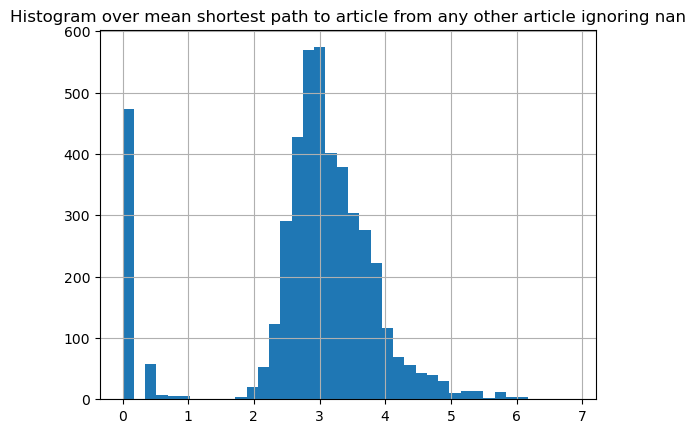

In [68]:
df_hubs.hist(column = "mean_shortest_path_to_article", bins = 40)
plt.title('Histogram over mean shortest path to article from any other article ignoring nan')
plt.show()

### Looking at some of the outliers

print('Printing articles with min distance 0.0')

In [103]:
min_value = df_hubs["mean_shortest_path"].min()

min_indices = df_hubs["article_names"].index[df_hubs["mean_shortest_path"] == min_value].tolist()

print('Articles with min distance', min_value)
df_hubs["article_names"].iloc[min_indices]

Articles with min distance 0.0


441                                                Badugi
970                                Color Graphics Adapter
1210                                          Directdebit
1231                                             Donation
1237                                         Douglas DC-4
1257                          Duchenne muscular dystrophy
2351                               Klinefelter's syndrome
2530                                      Local community
2543                                Lone Wolf (gamebooks)
3108                                         Osteomalacia
3352                                     Private Peaceful
3645                                        Schatzki ring
3928                                          Suikinkutsu
4289                                Underground (stories)
4333                                           Vacutainer
4480    Wikipedia Text of the GNU Free Documentation L...
4545                                          Wowpurchase
Name: article_

These articles have no path to them?

In [ ]:
#articles_small_mean

### Some basic plots exploring the data 

In [94]:
df_hubs.head()

,article_names,source_counts,target_counts,mean_shortest_path_to_article,mean_shortest_path,Art,Business Studies,Citizenship,Countries,Design and Technology,Everyday life,Geography,History,IT,Language and literature,Mathematics,Music,People,Religion,Science
0,Áedán mac Gabráin,11,0,0.0,3.395464,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,Åland,19,0,0.0,3.127959,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,Édouard Manet,20,0,0.0,3.171598,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Éire,8,0,0.0,3.325937,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,Óengus I of the Picts,10,0,0.0,3.386834,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [ ]:
#Create plot for each category for source counts and target counts
#Create plot similar plot for mean shortest path to/from article

In [ ]:
#Add category! How to read in the categories in a nice way....


/Users/lisavind/miniconda3/envs/ADA/lib/python3.11/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/lisavind/miniconda3/envs/ADA/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


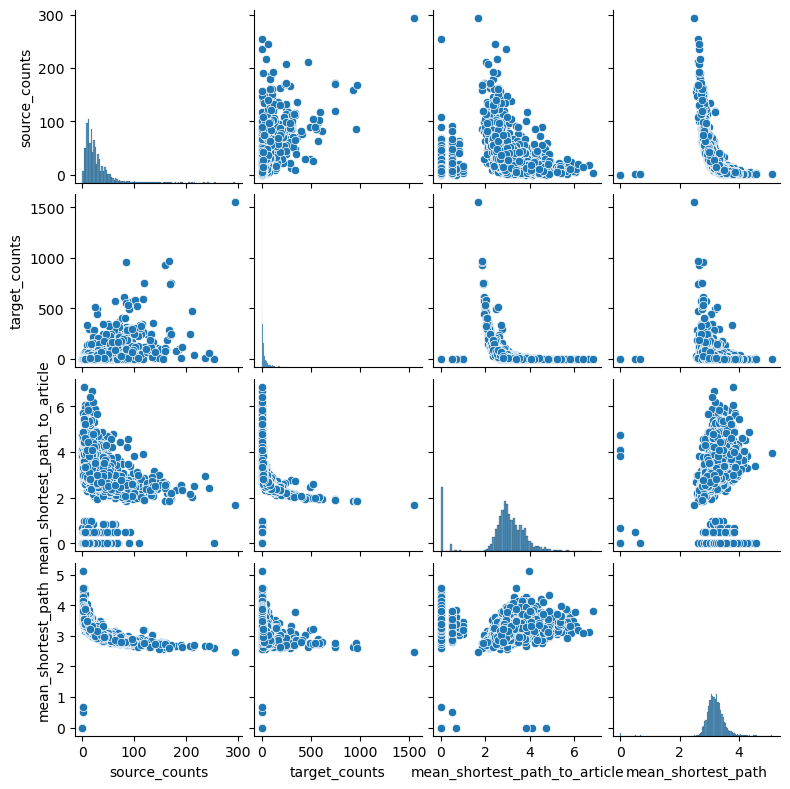

In [73]:
sns.pairplot(df_hubs, size = 2)



There are definitely some outliers here! I will look closer. Think these are cases where the articles are not really connected to the others

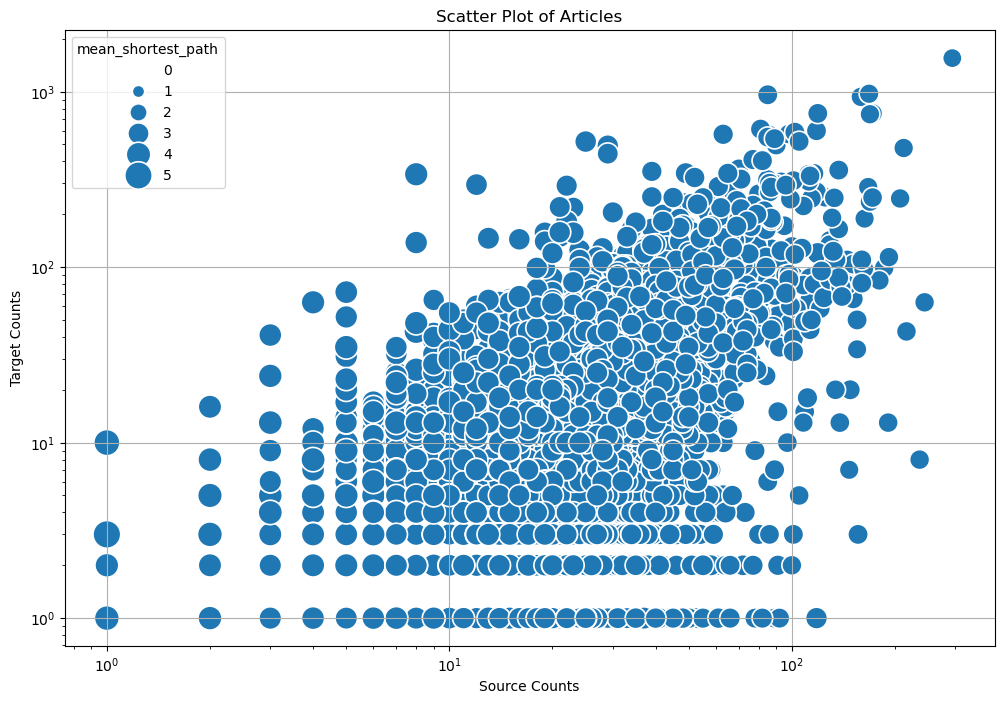

In [70]:
# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_hubs,
    x='source_counts',
    y='target_counts',
    size='mean_shortest_path',
    sizes=(2, 400)
)

plt.xscale('log')
plt.yscale('log')
plt.title('Scatter Plot of Articles')
plt.xlabel('Source Counts')
plt.ylabel('Target Counts')
plt.grid(True)
plt.show()

### Looking at distribution of categories

How to deal with articles which are apart of more than 1 main category?

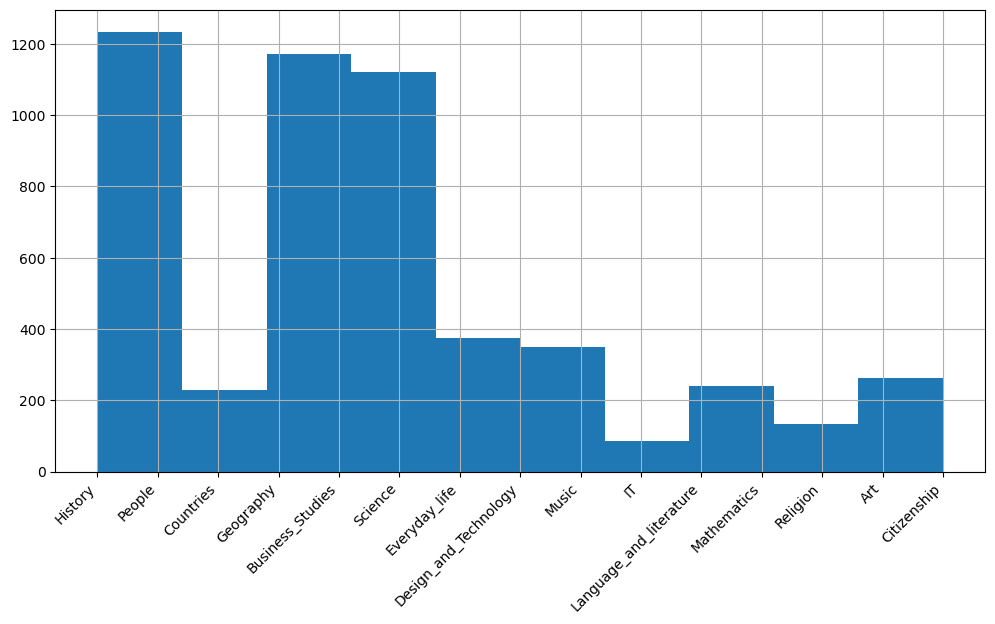

In [ ]:
#Compare most common articles in wikipidia
#With most visited articles in the game

fig = plt.figure(figsize=(12, 6))
dataframes["categories"][1].hist()
plt.xticks(rotation=45, ha='right')
plt.show()

### Looking at the mean shortest path distance grouped by subject

### Calculate how many subjects a given article is connected to